In [1]:
import numpy as np, os, sys
import pandas as pd
from scipy.io import loadmat
from scipy.signal import butter, lfilter
from scipy import stats

import heartpy as hp
import neurokit2 as nk

import matplotlib.pyplot as plt

from get_12ECG_features import get_12ECG_features_labels, detect_peaks

In [2]:
def process_signals(i, f, num_files, input_directory, df_raw):
    # print('    {}/{}...'.format(i+1, num_files))
    tmp_input_file = os.path.join(input_directory,f)
    data,header_data = load_challenge_data(tmp_input_file)
    
    features = get_HRVs_values(data, header_data)
    return features

In [3]:
def process_p_peaks(i, f, num_files, input_directory, df_raw):
    # print('    {}/{}...'.format(i+1, num_files))
    tmp_input_file = os.path.join(input_directory,f)
    data,header_data = load_challenge_data(tmp_input_file)
    
    features = get_pPeaks(data, header_data)
    return features

In [4]:
def load_challenge_data(filename):

    x = loadmat(filename)
    data = np.asarray(x['val'], dtype=np.float64)

    new_file = filename.replace('.mat','.hea')
    input_header_file = os.path.join(new_file)

    with open(input_header_file,'r') as f:
        header_data=f.readlines()


    return data, header_data

In [5]:
input_directory = '../Training_WFDB'

input_files = []
for f in os.listdir(input_directory):
    if os.path.isfile(os.path.join(input_directory, f)) and not f.lower().startswith('.') and f.lower().endswith('mat'):
        input_files.append(f)
        
df_raw = pd.DataFrame()
num_files = len(input_files)

In [6]:
def get_HRVs_values(data, header_data):

    filter_lowcut = 0.001
    filter_highcut = 15.0
    filter_order = 1

    tmp_hea = header_data[0].split(' ')
    ptID = tmp_hea[0]
    num_leads = int(tmp_hea[1])
    sample_Fs= int(tmp_hea[2])
    gain_lead = np.zeros(num_leads)
    
    for ii in range(num_leads):
        tmp_hea = header_data[ii+1].split(' ')
        gain_lead[ii] = int(tmp_hea[2].split('/')[0])


    for iline in header_data:
        if iline.startswith('#Age'):
            tmp_age = iline.split(': ')[1].strip()
            age = int(tmp_age if tmp_age != 'NaN' else np.nan())
            age = int(tmp_age)
        elif iline.startswith('#Sex'):
            tmp_sex = iline.split(': ')[1]
            if tmp_sex.strip()=='Female':
                sex =1
            else:
                sex=0
        elif iline.startswith('#Dx'):
            label = iline.split(': ')[1].split(',')[0]
            #label = iline.split(': ')[1].split(',')

    signal = data[1]
    gain = gain_lead[1]

    ecg_signal = nk.ecg_clean(signal*gain, sampling_rate=sample_Fs, method="biosppy")
    _ , rpeaks = nk.ecg_peaks(ecg_signal, sampling_rate=sample_Fs)
    hrv_time = nk.hrv_time(rpeaks, sampling_rate=sample_Fs)
    
    
    peaks = rpeaks['ECG_R_Peaks']
    
    
    # print(label, age)
    print(f'Paciente {label} Edad {age}')
    print(f'Duracion de la muestra: {len(signal) / sample_Fs} s')
    
    plt.figure(figsize=(20,5))
    plt.scatter(peaks, signal[np.array(peaks)]*gain, color='r')
    plt.plot(signal*gain)
    plt.show()
    
    
    win = 2500  # 5 segundos => 5 * sample_Fs
    rr_median = np.array([])
    
    for i in range(0, len(peaks), 1):
        # Me paro en el primer peak y miro 5s hacia adelante y hacia atras
        rg = np.array(range(peaks[i] - win, peaks[i] + win, 1))
        rr = []
        
        # Recorro el vector de peaks
        for x in range(len(peaks)):
            # Me fijo si hay algun peak dentro del rango definido
            if peaks[x] in rg:
                # Si encuentro uno lo agrego
                rr.append(peaks[x])
        
        # Paso mi vector rr de samples a tiempo
        rr = np.array(rr) / (sample_Fs)
        rr_diff = np.diff(rr)
        
        # Calculo la mediana movil para los peaks detectados dentro de la ventana
        rr_window = pd.Series(rr_diff).rolling(len(rr_diff)).median()
        rr_median = np.append(rr_median, rr_window.dropna())
    
    print('Intervalos RR con filtro de mediana:')
    print(f'{rr_median} \n')
    # print(stats.tvar(np.diff(rr_median)))
    print(f'Varianza del vector RR filtrado: {stats.tvar(rr_median)}')
    
        
    hrv_time['age'] = age
    hrv_time['label'] = label
    
    return hrv_time

In [54]:
def get_pPeaks(data, header_data):

    filter_lowcut = 0.001
    filter_highcut = 15.0
    filter_order = 1

    tmp_hea = header_data[0].split(' ')
    ptID = tmp_hea[0]
    num_leads = int(tmp_hea[1])
    sample_Fs= int(tmp_hea[2])
    gain_lead = np.zeros(num_leads)
    
    for ii in range(num_leads):
        tmp_hea = header_data[ii+1].split(' ')
        gain_lead[ii] = int(tmp_hea[2].split('/')[0])


    for iline in header_data:
        if iline.startswith('#Age'):
            tmp_age = iline.split(': ')[1].strip()
            age = int(tmp_age if tmp_age != 'NaN' else np.nan())
            age = int(tmp_age)
        elif iline.startswith('#Sex'):
            tmp_sex = iline.split(': ')[1]
            if tmp_sex.strip()=='Female':
                sex =1
            else:
                sex=0
        elif iline.startswith('#Dx'):
            label = iline.split(': ')[1].split(',')[0]
            #label = iline.split(': ')[1].split(',')

    signal = data[1]
    gain = gain_lead[1]

    ecg_signal = nk.ecg_clean(signal*gain, sampling_rate=sample_Fs, method="biosppy")
    _ , rpeaks = nk.ecg_peaks(ecg_signal, sampling_rate=sample_Fs)
    
    try:
        signal_peak, waves_peak = nk.ecg_delineate(ecg_signal, rpeaks, sampling_rate=sample_Fs)
        p_peaks = waves_peak['ECG_P_Peaks']
        p_time = [x/sample_Fs for x in p_peaks]
        p_diff = np.diff(p_time)
        print(f'Varianza del vector de diferencias {stats.tvar(p_diff)}')
        print(f'Varianza del vector de amplitudes P {stats.tvar(signal[np.array(p_peaks)])}')
    except ValueError:
        print('Exception raised!')
        pass
    
    print(f'Paciente {label} Edad {age}')
    print(f'Duracion de la muestra: {len(signal) / sample_Fs} s')
    
    f = [x/sample_Fs for x in range(len(signal))]
    
    plt.figure(figsize=(20,5))
    plt.scatter([peak/sample_Fs for peak in p_peaks] , signal[np.array(p_peaks)]*gain, color='r')
    plt.plot(f, signal*gain)
    plt.show()

Varianza del vector de diferencias 0.0061841777777777995
Varianza del vector de amplitudes P 888.5636363636364
Paciente PAC
 Edad 64
Duracion de la muestra: 10.0 s


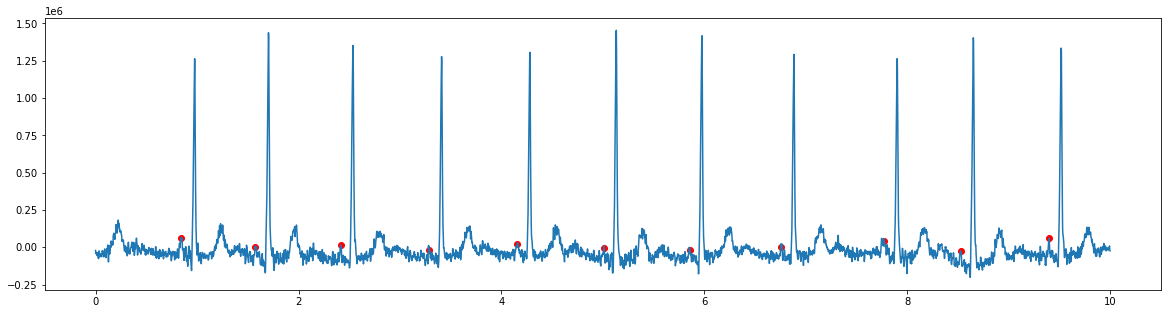



Varianza del vector de diferencias 0.002103957894736859
Varianza del vector de amplitudes P 222.24761904761908
Paciente Normal
 Edad 24
Duracion de la muestra: 20.0 s


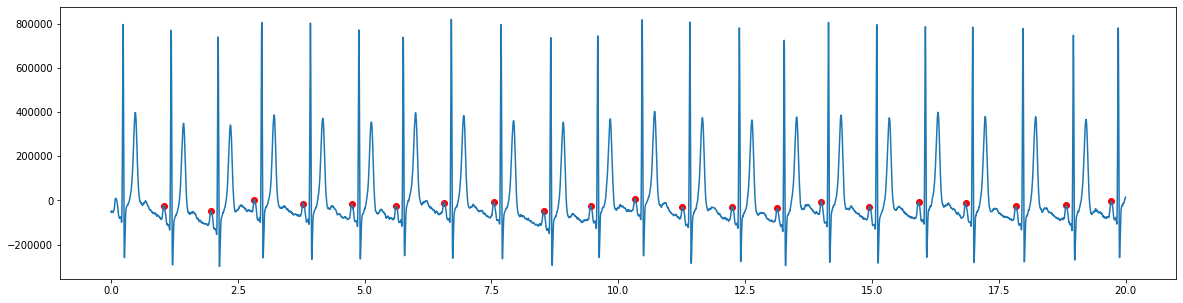



Varianza del vector de diferencias 0.009679670329670322
Varianza del vector de amplitudes P 307.6380952380952
Paciente PAC
 Edad 59
Duracion de la muestra: 14.224 s


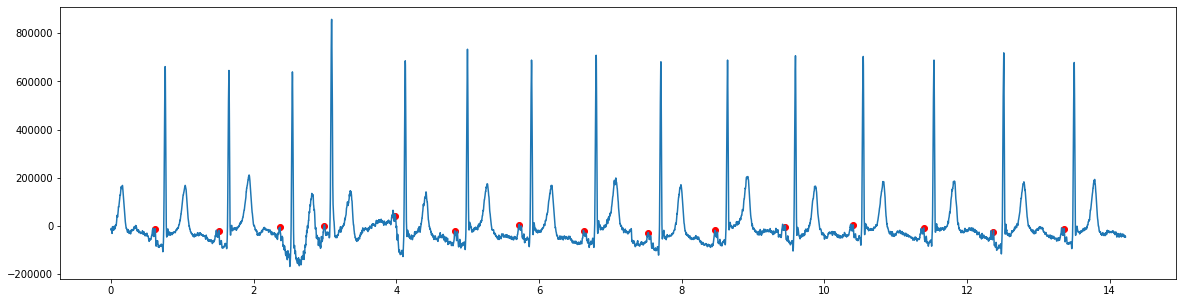



Varianza del vector de diferencias 0.0008847999999999909
Varianza del vector de amplitudes P 19.14761904761905
Paciente Normal
 Edad 14
Duracion de la muestra: 14.0 s


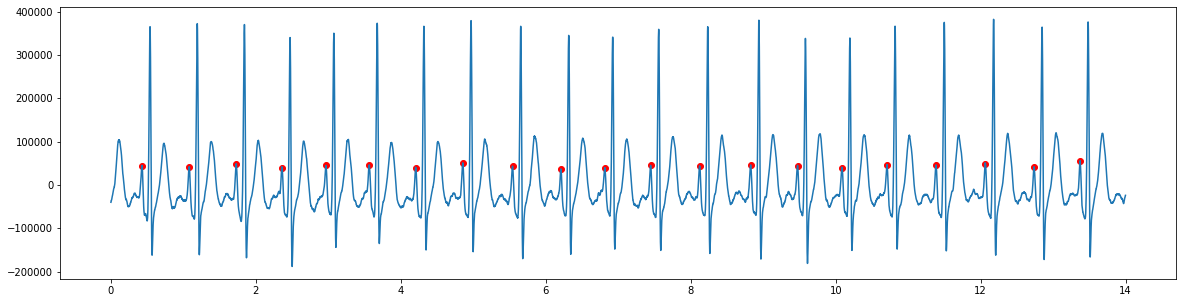



Varianza del vector de diferencias 0.00048448888888889623
Varianza del vector de amplitudes P 24.218181818181822
Paciente RBBB
 Edad 40
Duracion de la muestra: 11.0 s


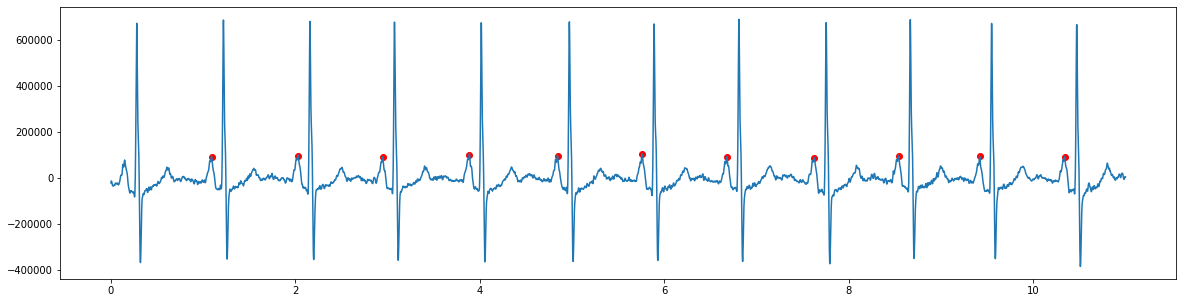



Varianza del vector de diferencias 0.0009057101449275204
Varianza del vector de amplitudes P 109.16666666666667
Paciente I-AVB
 Edad 64
Duracion de la muestra: 19.0 s


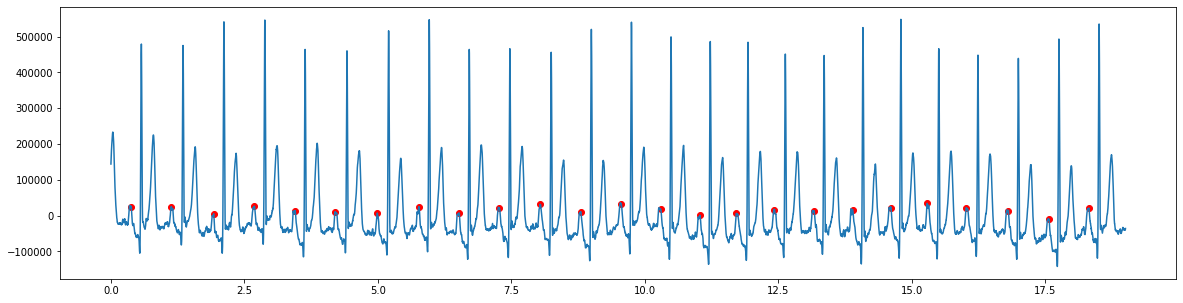



Varianza del vector de diferencias 0.08618719999999994
Varianza del vector de amplitudes P 1684.2424242424242
Paciente AF
 Edad 56
Duracion de la muestra: 10.0 s


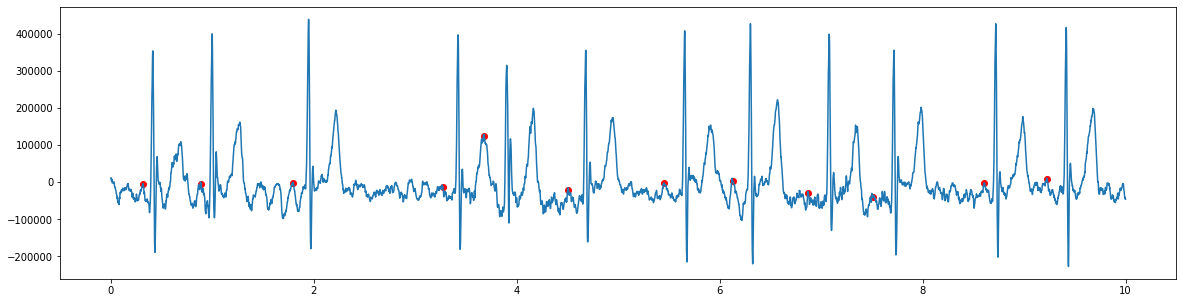



Varianza del vector de diferencias 0.02570698901098897
Varianza del vector de amplitudes P 735.8571428571429
Paciente AF Edad 76
Duracion de la muestra: 10.0 s


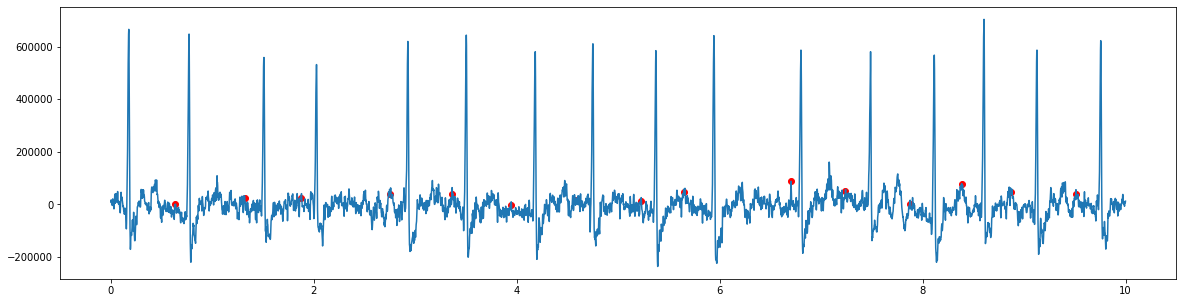



Varianza del vector de diferencias 0.015131076923076905
Varianza del vector de amplitudes P 1153.4120879120878
Paciente RBBB Edad 89
Duracion de la muestra: 10.0 s


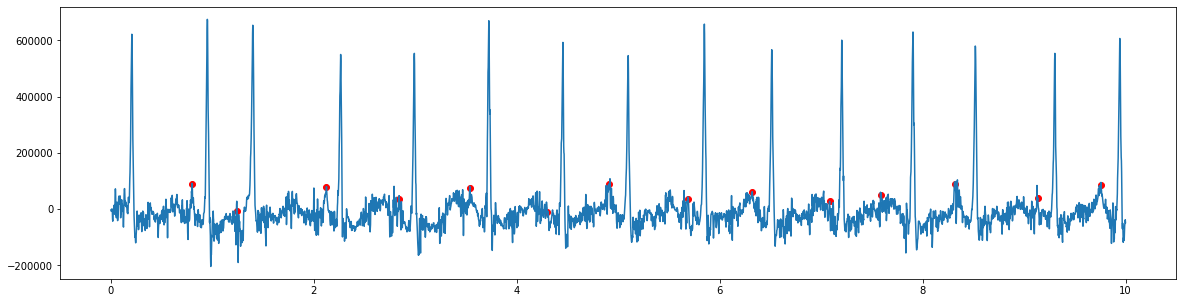



Varianza del vector de diferencias 0.0230832727272728
Varianza del vector de amplitudes P 3920.9230769230767
Paciente PVC
 Edad 42
Duracion de la muestra: 10.0 s


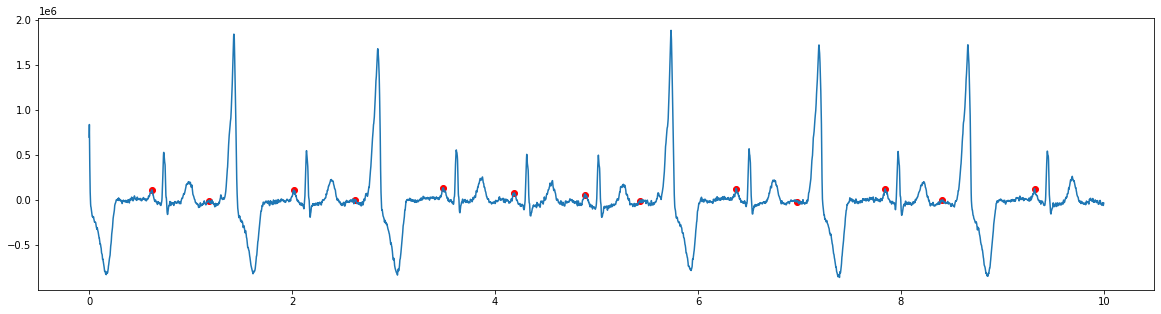



Varianza del vector de diferencias 0.04593904575163402
Varianza del vector de amplitudes P 1264.3567251461986
Paciente AF
 Edad 80
Duracion de la muestra: 14.0 s


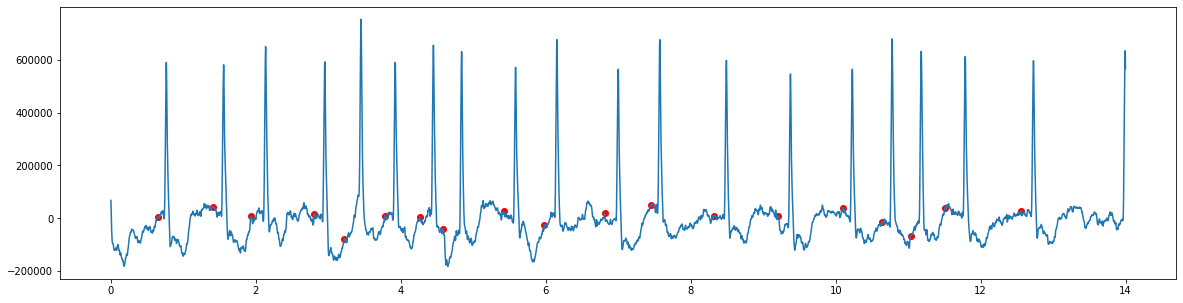



Varianza del vector de diferencias 0.04204025825825833
Varianza del vector de amplitudes P 4449.661450924609
Paciente PVC
 Edad 62
Duracion de la muestra: 32.436 s


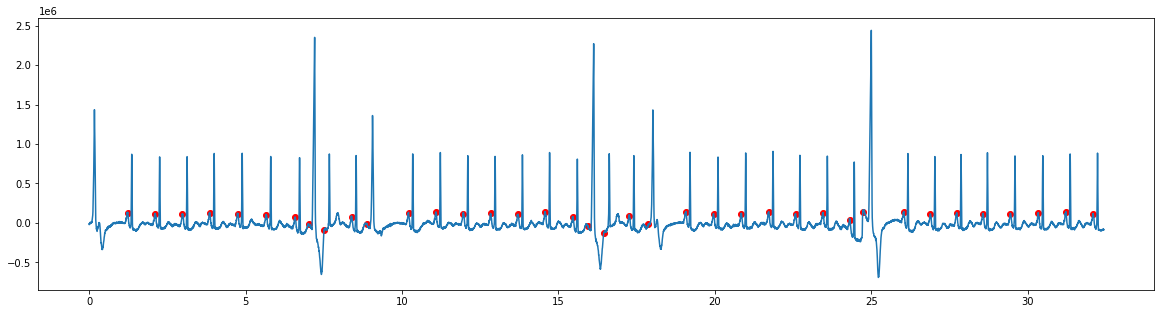



Varianza del vector de diferencias 0.03704497435897443
Varianza del vector de amplitudes P 2220.8626373626375
Paciente LBBB
 Edad 76
Duracion de la muestra: 10.0 s


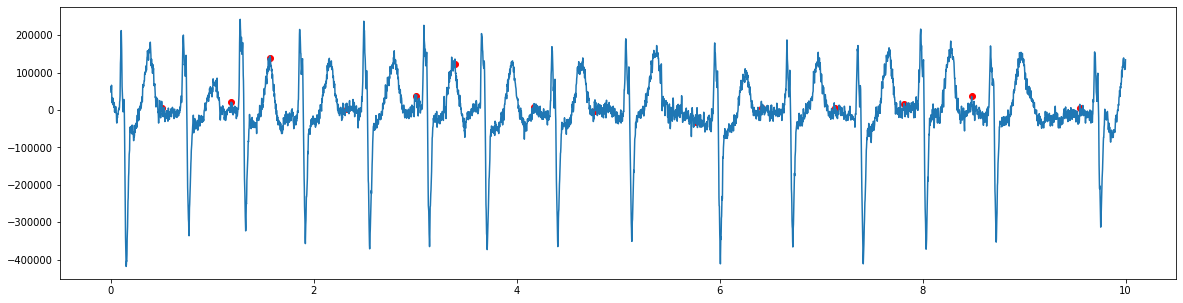



Varianza del vector de diferencias 0.0029334095238095167
Varianza del vector de amplitudes P 1092.6
Paciente RBBB
 Edad 76
Duracion de la muestra: 15.0 s


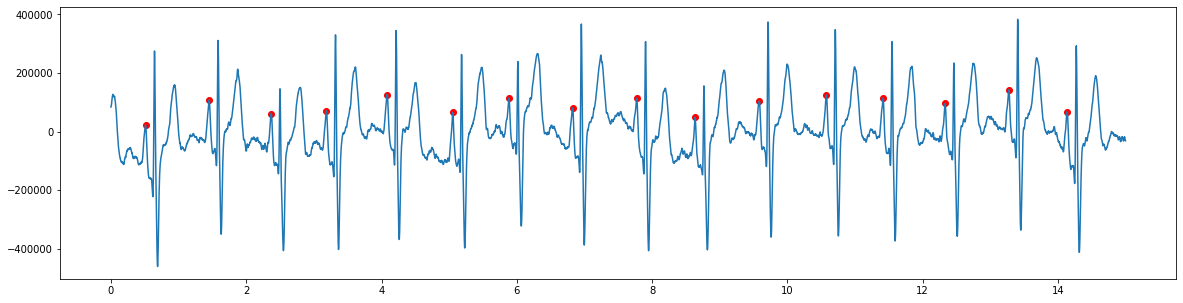



Varianza del vector de diferencias 0.064326
Varianza del vector de amplitudes P 610.9444444444445
Paciente I-AVB
 Edad 81
Duracion de la muestra: 10.0 s


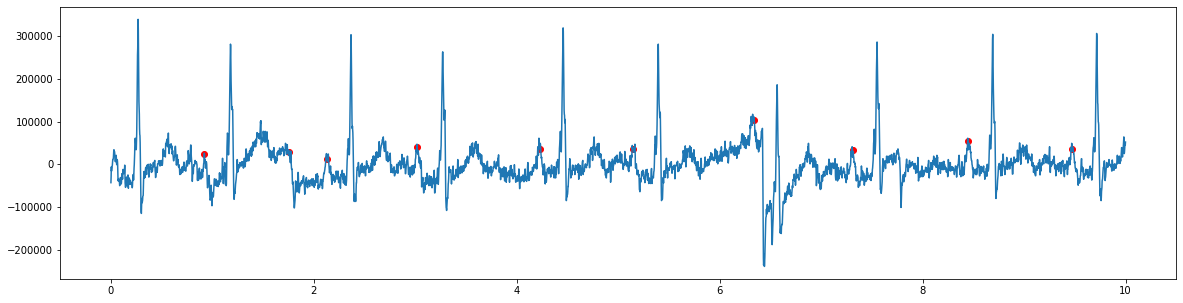



Varianza del vector de diferencias 0.01585906315789473
Varianza del vector de amplitudes P 283.2285714285714
Paciente PAC
 Edad 68
Duracion de la muestra: 21.0 s


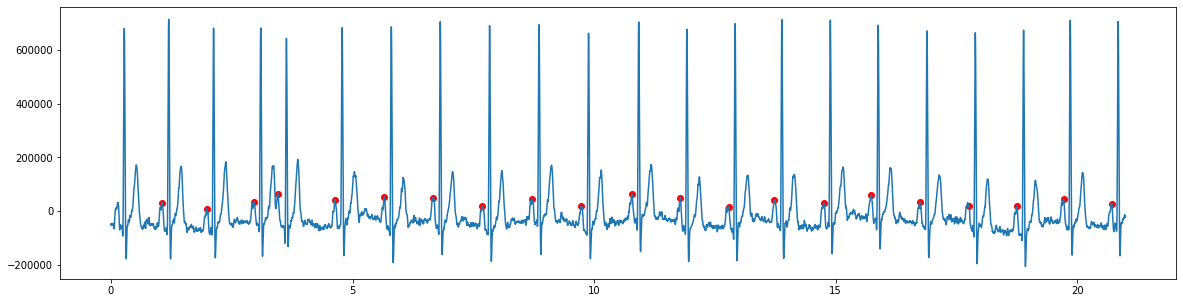



Varianza del vector de diferencias 0.035240058823529416
Varianza del vector de amplitudes P 2756.5653594771243
Paciente PAC
 Edad 35
Duracion de la muestra: 12.0 s


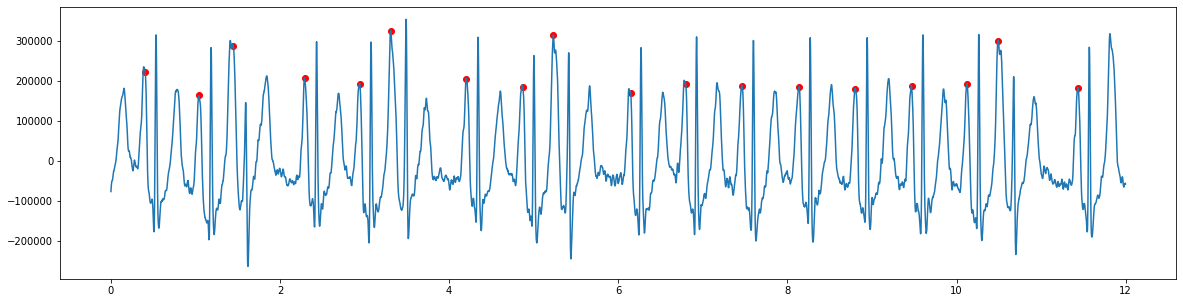



Varianza del vector de diferencias 2.0457142857142444e-05
Varianza del vector de amplitudes P 1236.9291666666666
Paciente LBBB
 Edad 78
Duracion de la muestra: 10.0 s


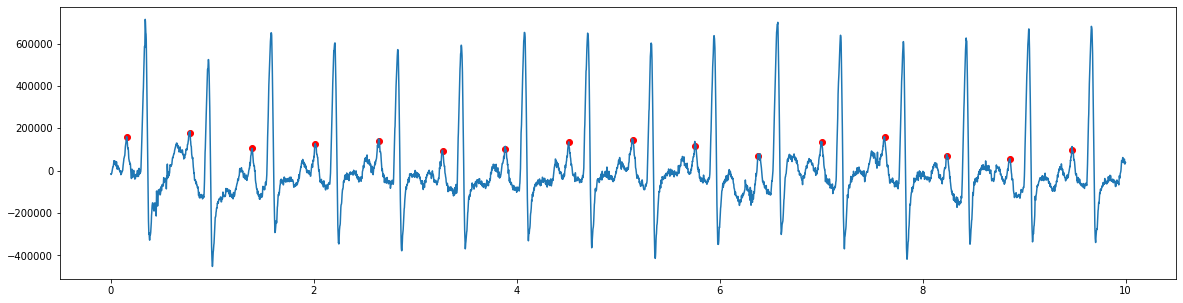



Varianza del vector de diferencias 0.013044606060606012
Varianza del vector de amplitudes P 264.3589743589743
Paciente AF Edad 91
Duracion de la muestra: 10.0 s


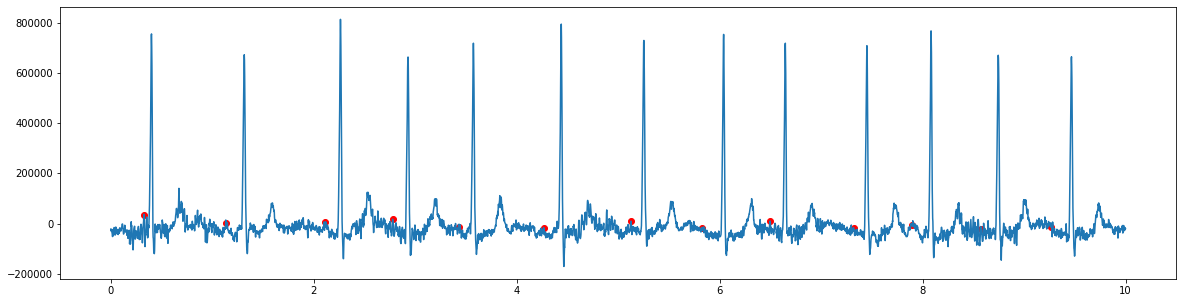



Varianza del vector de diferencias 0.00018142424242423904
Varianza del vector de amplitudes P 3874.5769230769233
Paciente RBBB
 Edad 68
Duracion de la muestra: 10.0 s


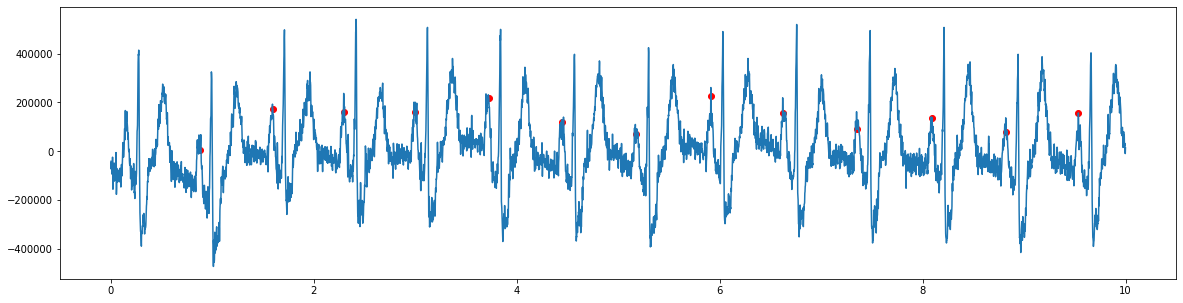

In [55]:
for i, f in enumerate(input_files[:20]):
    process_p_peaks(i, f, num_files, input_directory, df_raw)
    print('\n')